## Libraries

In [1]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import adjusted_mutual_info_score
from scipy.special import psi
from scipy.stats import pearsonr
from scipy.stats import skew, kurtosis
from collections import Counter, defaultdict
from multiprocessing import Pool
import pandas as pd
import operator
import hsic
import math
import networkx as nx
import matplotlib.pyplot as plt

## Test Code

In [2]:
x = np.array([[1, 2, 3, 5],
              [1, 2, 4, 5],
              [2, 3, 6, 5]])

In [3]:
def weighted_mean_and_std(x, weights):
    """
    Returns the weighted average and standard deviation. [d, 2]

    values, weights -- numpy ndarrays with the shape of [n, d] and [n], respectively.
    """
    average = np.average(x, weights=weights, axis=0)
    variance = np.dot(weights, (x-average)**2)/weights.sum()  # Fast and numerically precise
    return (average, np.sqrt(variance))

weighted_mean_and_std(x, weights=np.array([1, 1, 1]))

(array([1.33333333, 2.33333333, 4.33333333, 5.        ]),
 array([0.47140452, 0.47140452, 1.24721913, 0.        ]))

In [4]:
def weighted_mean(x, weights):
    """
    Returns the weighted average. [d]

    x, weights -- numpy ndarrays with the shape of [n, d] and [n], respectively.
    """
    return np.average(x, weights=weights, axis=0)

weighted_mean(x, weights=np.array([1, 1, 1]))

array([1.33333333, 2.33333333, 4.33333333, 5.        ])

In [5]:
def weighted_std(x, weights):
    """
    Returns the weighted standard deviation. [d]

    x, weights -- numpy ndarrays with the shape of [n, d] and [n], respectively.
    """
    return np.sqrt(np.dot(weights, (x-weighted_mean(x, weights))**2)/weights.sum())

weighted_std(x, weights=np.array([1, 1, 1]))

array([0.47140452, 0.47140452, 1.24721913, 0.        ])

In [6]:
def count_unique_per_node(x):
    """
    Returns the number of unique values for each column of the input array. [d]

    x -- numpy ndarray with the shape of [n, d].
    """
    return np.array([len(np.unique(x[:, i])) for i in range(x.shape[1])])

count_unique_per_node(x)

array([2, 2, 3, 1])

In [7]:
def count_unique_ratio_per_node(x):
    """
    Returns the ratio of unique values for each column of the input array. [d]

    x -- numpy ndarray with the shape of [n, d].
    """
    return np.array([len(set(x[:, i])) / float(len(x)) for i in range(x.shape[1])])

count_unique_ratio_per_node(x)

array([0.66666667, 0.66666667, 1.        , 0.33333333])

In [8]:
def normalize(x):
    x = x - np.mean(x)
    if np.std(x) > 0:
        x = x/np.std(x)
    return x 

normalize(x)

array([[-1.37248713, -0.76249285, -0.15249857,  1.06748999],
       [-1.37248713, -0.76249285,  0.45749571,  1.06748999],
       [-0.76249285, -0.15249857,  1.67748427,  1.06748999]])

In [9]:

def normalize_per_node(x):
    """
    Returns the normalized version of the input array, where each column is normalized to have a mean of 0 and a standard deviation of 1. [n, d]

    x -- numpy ndarray with the shape of [n, d].
    """
    x = x - np.mean(x, axis=0)  
    std = np.std(x, axis=0)      
    std[std == 0] = 1            
    x = x / std                  
    return x

normalize_per_node(x)

array([[-0.70710678, -0.70710678, -1.06904497,  0.        ],
       [-0.70710678, -0.70710678, -0.26726124,  0.        ],
       [ 1.41421356,  1.41421356,  1.33630621,  0.        ]])

In [10]:
def normalized_entropy_baseline(x):
    if len(set(x)) < 2:
        return 0
    x = normalize(x)
    xs = np.sort(x)
    delta = xs[1:] - xs[:-1]
    delta = delta[delta != 0]
    hx = np.mean(np.log(delta))
    hx += psi(len(delta))
    hx -= psi(1)
    return hx

normalize_per_node(x)

array([[-0.70710678, -0.70710678, -1.06904497,  0.        ],
       [-0.70710678, -0.70710678, -0.26726124,  0.        ],
       [ 1.41421356,  1.41421356,  1.33630621,  0.        ]])

In [11]:
def normalized_entropy_baseline(x):
    """
    Returns the normalized entropy baseline for each column of the input array. [d]

    x -- numpy ndarray with the shape of [n, d].
    """
    def entropy_per_column(column):
        column = normalize(column)
        xs = np.sort(column)
        delta = xs[1:] - xs[:-1]
        delta = delta[delta != 0]  # 0을 제외한 차이값들만 사용
        if len(delta) == 0:  # 모든 값이 동일할 경우 엔트로피는 0
            return 0
        hx = np.mean(np.log(delta))
        hx += psi(len(delta))
        hx -= psi(1)
        return hx

    return np.array([entropy_per_column(x[:, i]) for i in range(x.shape[1])])

normalized_entropy_baseline(x)

array([0.7520387 , 0.7520387 , 1.12565721, 0.        ])

In [12]:
def normalized_entropy_baseline(x):
    # if len(set(x)) < 2:
    #     return 0
    x = normalize(x)
    xs = np.sort(x)
    print("xs", xs)
    delta = xs[1:] - xs[:-1]
    print("delta", delta)
    delta = delta[delta != 0]
    print("ddd", delta)
    hx = np.mean(np.log(delta))
    print("hx", hx)
    hx += psi(len(delta))
    print("hhx", hx)
    hx -= psi(1)
    print("hhh", hx)
    return hx

y = [1, 1, 2]
normalized_entropy_baseline(y)

xs [-0.70710678 -0.70710678  1.41421356]
delta [0.         2.12132034]
ddd [2.12132034]
hx 0.752038698388137
hhx 0.1748230334866041
hhh 0.752038698388137


0.752038698388137

In [13]:
def normalized_entropy_baseline(x):
    """
    Returns the normalized entropy baseline for each column of the input array. [d]

    x -- numpy ndarray with the shape of [n, d].
    """
    # x를 열 단위로 정규화
    x = normalize_per_node(x)
    
    def entropy_per_column(column):
        xs = np.sort(column)  # 정렬
        delta = xs[1:] - xs[:-1]  # 인접 값 차이
        delta = delta[delta != 0]  # 0이 아닌 차이만 사용
        if len(delta) == 0:  # 모든 값이 동일할 경우
            return 0
        hx = np.mean(np.log(delta))
        hx += psi(len(delta))
        hx -= psi(1)
        return hx

    # 각 열에 대해 엔트로피 계산
    return np.array([entropy_per_column(x[:, i]) for i in range(x.shape[1])])

normalized_entropy_baseline(x)

array([0.7520387 , 0.7520387 , 1.12565721, 0.        ])

In [14]:
def normalized_entropy(x, m=2):
    """
    Returns the normalized entropy for each column of the input array. [d]

    x -- numpy ndarray with the shape of [n, d].
    m -- parameter for adjusting delta (default is 2)
    """
    x = normalize_per_node(x)

    def entropy_per_column(column):
        cx = Counter(column)  
        if len(cx) < 2:  
            return 0
        xk = np.array(list(cx.keys()), dtype=float)  
        xk.sort()  
        delta = (xk[1:] - xk[:-1]) / m  
        counter = np.array([cx[i] for i in xk], dtype=float) 
        hx = np.sum(counter[1:] * np.log(delta / counter[1:])) / len(column)  
        hx += (psi(len(delta)) - np.log(len(delta)))
        hx += np.log(len(column))
        hx -= (psi(m) - np.log(m))
        return hx

    return np.array([entropy_per_column(x[:, i]) for i in range(x.shape[1])])


normalized_entropy(x)

array([0.81138998, 0.81138998, 0.72028564, 0.        ])

In [15]:
def normalized_skewness(x):
    return skew(normalize_per_node(x))

normalized_skewness(x)

array([0.70710678, 0.70710678, 0.38180177,        nan])

In [16]:
def normalized_skewness(x):
    """
    Returns the skewness of the normalized input array for each column.

    x -- numpy ndarray with the shape of [n, d].
    """
    x = normalize_per_node(x)
    # 각 열의 왜도를 계산, 만약 모든 값이 동일하면 왜도를 0으로 설정
    return np.array([0 if np.all(x[:, i] == x[0, i]) else skew(x[:, i]) for i in range(x.shape[1])])

normalized_skewness(x)

array([0.70710678, 0.70710678, 0.38180177, 0.        ])

In [17]:
def normalized_kurtosis(x):
    return kurtosis(normalize_per_node(x))

normalized_kurtosis(x)

array([-1.5, -1.5, -1.5,  nan])

In [18]:
def normalized_kurtosis(x):
    """
    Returns the kurtosis of the normalized input array for each column.

    x -- numpy ndarray with the shape of [n, d].
    """
    x = normalize_per_node(x)
    return np.array([0 if np.all(x[:, i] == x[0, i]) else kurtosis(x[:, i]) for i in range(x.shape[1])])

normalized_kurtosis(x)

array([-1.5, -1.5, -1.5,  0. ])

In [19]:
def uniform_divergence(x, m=2):
    """
    Returns the uniform divergence for each column of the input array. [d]

    x -- numpy ndarray with the shape of [n, d].
    m -- parameter for adjusting delta (default is 2)
    """
    x = normalize_per_node(x)

    def divergence_per_column(column):
        cx = Counter(column)  
        xk = np.array(list(cx.keys()), dtype=float)  
        if len(xk) <= 1:  
            return 0
        xk.sort()  
        delta = np.zeros(len(xk))  
        delta[0] = xk[1] - xk[0]  
        delta[1:-1] = (xk[m:] - xk[:-m]) / m  
        delta[-1] = xk[-1] - xk[-2]  
        counter = np.array([cx[i] for i in xk], dtype=float)  
        delta = delta / np.sum(delta)  
        hx = np.sum(counter * np.log(counter / delta)) / len(column)  
        hx -= np.log(len(column))  
        hx += (psi(m) - np.log(m)) 
        return hx

    return np.array([divergence_per_column(x[:, i]) for i in range(x.shape[1])])

uniform_divergence(x)

array([-0.21372983, -0.21372983, -0.23110183,  0.        ])

In [20]:
class MultiColumnTransform(BaseEstimator):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X)

    def transform(self, X, y=None):
        # X가 ndarray일 경우 각 행을 순회하며 transformer에 전달
        return np.array([self.transformer(column) for column in X.T], ndmin=2).T

In [21]:
def normalized_entropy_baseline(x):
    if len(set(x)) < 2:
        return 0
    x = normalize(x)
    xs = np.sort(x)
    delta = xs[1:] - xs[:-1]
    delta = delta[delta != 0]
    hx = np.mean(np.log(delta))
    hx += psi(len(delta))
    hx -= psi(1)
    return hx

In [22]:
extractor = MultiColumnTransform(normalized_entropy_baseline)

In [23]:
y = extractor.transform(x)
y

array([[0.7520387 ],
       [0.7520387 ],
       [1.12565721],
       [0.        ]])

In [24]:
y.shape

(4, 1)

In [25]:
extractor2 = MultiColumnTransform(np.max)
y2 = extractor2.transform(x)
y2

array([[2],
       [3],
       [6],
       [5]])

In [26]:
np.concatenate((y, y2), axis=1)

array([[0.7520387 , 2.        ],
       [0.7520387 , 3.        ],
       [1.12565721, 6.        ],
       [0.        , 5.        ]])

In [27]:
# def Erdos_Renyi_DAG(num_vars: int, num_edges: int) -> nx.DiGraph:
#     G = nx.gnm_random_graph(num_vars, num_edges)
#     adjmat_G = nx.to_numpy_array(G)
#     adjmat_DAG = np.tril(adjmat_G, -1)
#     DAG = nx.DiGraph(adjmat_DAG)
#     return DAG

In [2]:
import numpy as np
from scipy.special import expit as sigmoid
import igraph as ig
import random
import argparse
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()


def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d))+1, directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def simulate_parameter(B, w_ranges=((-2.0, -0.5), (0.5, 2.0))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    return W


def simulate_linear_sem(W, n, sem_type, noise_scale=None):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = np.random.normal(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')
    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
    return X


def simulate_nonlinear_sem(B, n, sem_type='mlp', noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X


def generate_data(n, d, s0, graph_type, linear_sem_type, nonlinear_sem_type, type, seed, save_dir):
    set_random_seed(seed)

    # make data folder
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    existing_folders = sorted([f for f in os.listdir(save_dir) if os.path.isdir(os.path.join(save_dir, f))])
    if existing_folders:
        new_folder_num = int(existing_folders[-1]) + 1
    else:
        new_folder_num = 1

    new_folder_name = f'{new_folder_num:03}'
    new_folder_path = os.path.join(save_dir, new_folder_name)    
    os.makedirs(new_folder_path)
    
    # linear sem
    if type == 'linear':
        B_true = simulate_dag(d, s0, graph_type)
        W_true = simulate_parameter(B_true)
        X = simulate_linear_sem(W_true, n, linear_sem_type)
        np.savetxt(os.path.join(new_folder_path, f'B_true_{graph_type}_{linear_sem_type}.csv'), B_true, delimiter=',')
        # 필요한지 확인..?
        np.savetxt(os.path.join(new_folder_path, f'W_true_{graph_type}_{linear_sem_type}.csv'), W_true, delimiter=',')
        np.savetxt(os.path.join(new_folder_path, f'X_{graph_type}_{linear_sem_type}.csv'), X, delimiter=',')
      
    # nonlinear sem
    else:
        B_true = simulate_dag(d, s0, graph_type)
        X = simulate_nonlinear_sem(B_true, n, nonlinear_sem_type)
        np.savetxt(os.path.join(new_folder_path, f'B_true_{graph_type}_{nonlinear_sem_type}.csv'), B_true, delimiter=',')
        np.savetxt(os.path.join(new_folder_path, f'X_{graph_type}_{nonlinear_sem_type}.csv'), X, delimiter=',')

In [20]:
generate_data(n=500, d=10, s0=30, graph_type='ER', linear_sem_type='gauss', nonlinear_sem_type='mlp', type='linear', seed=4, save_dir = '/home/jina/reprod/data/new'
)

In [3]:
    
def visualize_dag(csv_path):
    adj_matrix = np.loadtxt(csv_path, delimiter=',')
    """Visualize the DAG using networkx and matplotlib"""
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)  
    pos = nx.spring_layout(G, k= 1.5)  
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1000, arrows=True)
    plt.title("DAG Visualization")
    plt.show()

def visualize_matrix(csv_path):
    adj_matrix = np.loadtxt(csv_path, delimiter=',')
    plt.figure(figsize=(5, 5))
    sns.heatmap(adj_matrix, annot=True, cmap='Blues', cbar=False)
    plt.gca().xaxis.set_label_position('top') 
    plt.gca().xaxis.tick_top()  
    plt.title('Adjacency Matrix Visualization')
    plt.show()

In [21]:
csv1 = '/home/jina/reprod/data/new/001/B_true_ER_gauss.csv'
csv2 = '/home/jina/reprod/data/new/003/B_true_ER_gauss.csv'
# csv3 = 'C:\\Users\\wlsdk\\Desktop\\GSDS\\grad\\code\\jina\\data\\train\\003\\B_true_SF_gauss.csv'
# csv4 = 'C:\\Users\\wlsdk\\Desktop\\GSDS\\grad\\code\\jina\\data\\train\\004\\B_true_SF_mlp.csv'

In [22]:
csv_paths = [csv1, csv2]

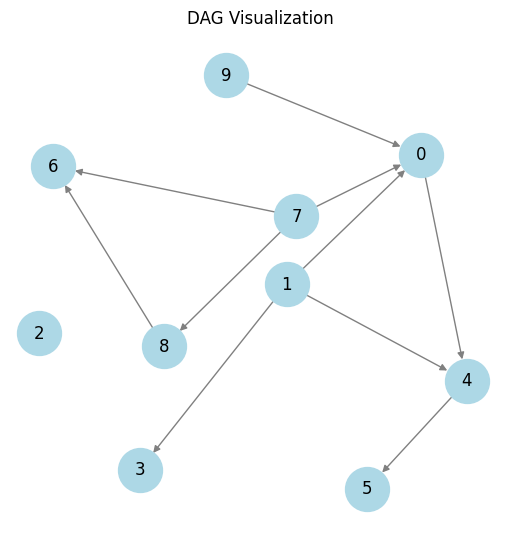

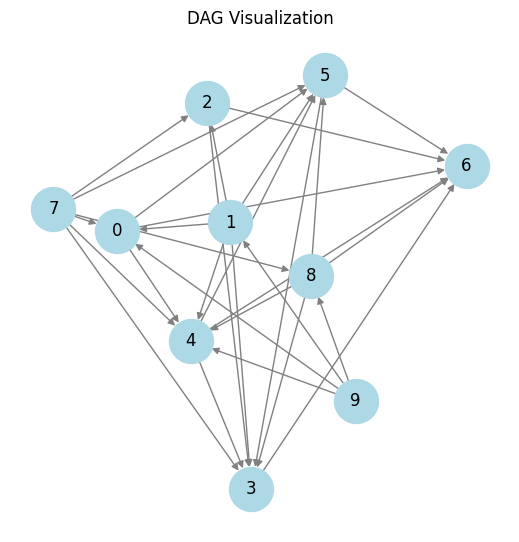

In [23]:
for csv in csv_paths:
    visualize_dag(csv)

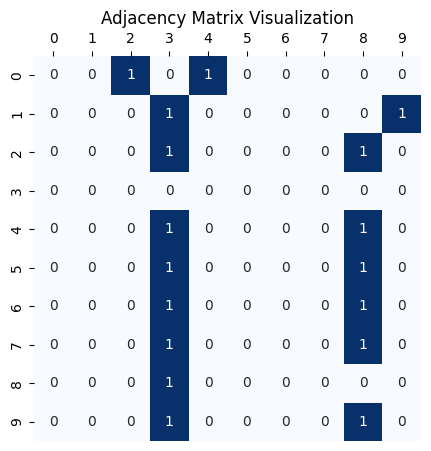

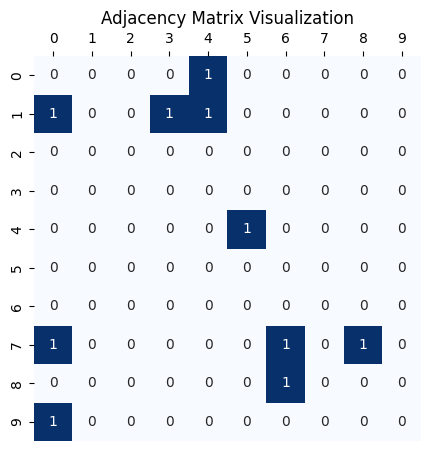

In [39]:
for csv in csv_paths:
    visualize_matrix(csv)

In [40]:
x_csv = '/home/jina/reprod/data/train/002/X_ER_gauss.csv'
df = pd.read_csv(x_csv, header=None).head(20)
df.columns = [f'N{i+1}' for i in range(df.shape[1])]
df

N1        N2        N3        N4        N5        N6        N7  \
0   2.811409  0.409098 -0.137976  0.416122 -1.495846 -1.025604 -0.206977   
1   2.853766  0.648782 -1.722699 -1.197309 -4.079873 -5.041860 -2.354700   
2   1.570100  1.234469 -1.622394 -0.933452 -2.779500 -1.692017 -0.178553   
3  -0.235806  0.377992 -0.610172 -1.668979 -1.333078 -0.513534  1.566488   
4   1.990453 -0.905818 -2.794575  0.093474 -0.055246 -0.748425 -0.036711   
5   0.254253  0.424654  0.983120 -0.887379 -1.447827 -0.958696  0.309933   
6  -1.921262 -0.641012  0.152361  0.316887  2.161967  0.455361 -0.509886   
7   1.456037  0.179306 -0.043168 -0.963566 -1.612524 -1.281848 -1.671456   
8  -1.203127  0.162592  0.972298  2.210592  0.578824  1.901660  0.478649   
9  -0.930626  0.228069 -0.798262  0.636459  1.842788  2.211758 -0.267088   
10 -1.087644 -0.711410 -0.095035 -0.140146  2.050549  0.722526  0.051050   
11 -3.701722 -0.853640 -0.160723  1.185685  4.249025  5.352777 -0.684610   
12 -1.489154 -0.056715  0.129216 -0.093294  3.090286  3.232004  1.422124   
13 -4.576428 -1.620463 -0.480528  0.571515  7.092768  6.946617 -0.412286   
14  0.534342  0.035527  1.412529  0.085208 -1.302881 -1.947771  0.772811   
15  0.483522  1.709707 -1.350627 -1.864751 -2.202795  0.007253  1.048188   
16 -1.643706  0.240355 -0.799846  1.174434  0.046739  0.355161  4.032538   
17 -1.739086  0.236787 -0.076815 -1.926985  0.174715 -1.717518 -1.993414   
18  0.932372  0.070162  0.366066 -0.356521 -0.872569 -0.683962  2.653252   
19  3.358203  0.491204 -0.799664  2.406322 -3.929820 -3.052512  0.389266   

          N8        N9       N10  
0  -1.220439 -0.109982 -0.187993  
1  -1.136902  0.599902 -0.557695  
2  -1.312486 -1.493146  0.825745  
3   0.433638  0.014205  0.851937  
4  -1.149233 -1.085218 -0.804105  
5   0.813974  0.178130 -0.094066  
6  -0.369916 -1.367512  0.105611  
7  -0.371857  0.587772 -0.791996  
8   1.370870  1.533979 -0.413880  
9   1.039392  1.524639 -0.107766  
10 -0.263517  0.284419  0.244096  
11  1.142856  1.989273 -0.284107  
12  2.101819  1.479392 -1.025021  
13  0.338498  0.658657  0.121878  
14  0.236706  0.547634 -1.002624  
15  0.700801 -0.657659  1.352605  
16  0.763099 -0.854059  1.410067  
17  1.413590  1.520048  0.078702  
18 -0.373335 -0.709271 -0.106040  
19 -2.609276 -3.196826  0.366476

In [1]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.metrics import adjusted_mutual_info_score
from scipy.special import psi
from scipy.stats import pearsonr
from scipy.stats import skew, kurtosis
from collections import Counter, defaultdict
from multiprocessing import Pool
import pandas as pd
import operator
import hsic
import math
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
x = np.array([[1, 2, 3, 5],
              [1, 2, 4, 5],
              [2, 3, 6, 5]])

In [3]:
x_df = pd.DataFrame(x)
x_df

0  1  2  3
0  1  2  3  5
1  1  2  4  5
2  2  3  6  5

In [2]:
import features as ft

class MultiColumnTransform(BaseEstimator):
    def __init__(self, transformer, *args):
        self.transformer = transformer
        self.args = args

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X)

    def transform(self, X, y=None):
        if self.args:
            return np.array([self.transformer(column, *self.args) for column in X.T], ndmin=2).T
        else:
            # return X.apply(self.transformer, axis=0).to_numpy().T
            return np.array([self.transformer(column) for column in X.T], ndmin=2).T
    
node_features = [
    ('Max', MultiColumnTransform(np.max)),
    ('Min', MultiColumnTransform(np.min)),
    ('Normalized Entropy Baseline', MultiColumnTransform(ft.normalized_entropy_baseline)),
    ('Normalized Entropy', MultiColumnTransform(ft.normalized_entropy)),
    ('Uniform Divergence', MultiColumnTransform(ft.uniform_divergence)),
    ('Skewness', MultiColumnTransform(ft.normalized_skewness)),
    ('Kurtosis', MultiColumnTransform(ft.normalized_kurtosis)),
    ('weighted_mean', MultiColumnTransform(ft.weighted_mean)),
    ('weighted_std', MultiColumnTransform(ft.weighted_std)),
    ('Interquartile Range', MultiColumnTransform(lambda x: np.percentile(x, 75) - np.percentile(x, 25))),
    # ('Median', MultiColumnTransform(np.median)),
    ('Coefficient of Variation', MultiColumnTransform(lambda x: np.std(x) / np.mean(x) if np.mean(x) != 0 else 0)),
    # ('Shannon Diversity Index', MultiColumnTransform(lambda x: -np.sum(x * np.log(x)) if np.all(x > 0) else 0)),

    
]

In [20]:
# 빈 배열로 시작
result = []
x_df_num = x_df.to_numpy()

for name, extractor in node_features:
    y = extractor.transform(x_df_num)
    print(y.shape)
    
    # 첫 번째 반복에서는 빈 리스트를 채우기 위해 초기화, 이후에는 열로 붙이기
    if len(result) == 0:
        result = y
    else:
        result = np.column_stack([result, y])

pd.DataFrame(result)

(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)
(4, 1)


0    1         2         3         4         5    6         7         8   \
0  2.0  1.0  0.752039  0.811390 -0.213730  0.707107 -1.5  1.333333  0.471405   
1  3.0  2.0  0.752039  0.811390 -0.213730  0.707107 -1.5  2.333333  0.471405   
2  6.0  3.0  1.125657  0.720286 -0.231102  0.381802 -1.5  4.333333  1.247219   
3  5.0  5.0  0.000000  0.000000 -0.270363  0.000000  0.0  5.000000  0.000000   

    9         10  
0  0.5  0.353553  
1  0.5  0.202031  
2  1.5  0.287820  
3  0.0  0.000000

In [21]:
x_df

0  1  2  3
0  1  2  3  5
1  1  2  4  5
2  2  3  6  5

In [3]:
class SimpleTransform(BaseEstimator):
    def __init__(self, transformer, *args):
        self.transformer = transformer
        self.args = args

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X)

    def transform(self, X, y=None):
        if self.args:
            return np.array([self.transformer(X, *self.args)], ndmin=2).T
        # return np.array([self.transformer(x) for x in X], ndmin=2).T
        else:
            return np.array([self.transformer(X)], ndmin=2).T
    
class PairColumnTransform(BaseEstimator):
    def __init__(self, transformer, *args):
        self.transformer = transformer
        self.args = args

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X1, X2, y=None):
        return self.transform(X1, X2)

    def transform(self, X1, X2, y=None):
        if self.args:
            # return np.array([self.transformer(c1, c2, *self.args) for c1, c2 in zip(X1.T, X2.T)], ndmin=2).T
            return np.array(self.transformer(X1.T, X2.T, *self.args), ndmin=2).T
        else:
            # return np.array([self.transformer(c1, c2) for c1, c2 in zip(X1.T, X2.T)], ndmin=2).T
            return np.array(self.transformer(X1.T, X2.T), ndmin=2).T

In [4]:
edge_features = [
    ('Sub_Numerical', PairColumnTransform(operator.sub), None),
    ('Sub_Normalized Entropy Baseline', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy_baseline)),
    ('Sub_Normalized Entropy', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy)),
    ('Sub_Normalized Entropy5', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy, 5)),
    ('Sub_Normalized Entropy5', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy, 10)),
    ('IGCI', PairColumnTransform(ft.igci), None),
    ('Sub_Uniform Divergence', PairColumnTransform(operator.sub), SimpleTransform(ft.uniform_divergence)),
    # ('Sub_Uniform Divergence5', PairColumnTransform(operator.sub), SimpleTransform(ft.uniform_divergence, 5)),
    ('Polyfit', PairColumnTransform(ft.fit), None),
    ('Polyfit Error', PairColumnTransform(ft.fit_error), None),
    ('Polyfit Error3', PairColumnTransform(ft.fit_error, 3), None),
    ('Polyfit Error5', PairColumnTransform(ft.fit_error, 5), None),
    ('fit_noise_entropy', PairColumnTransform(ft.fit_noise_entropy), None),
    ('fit_noise_entropy55', PairColumnTransform(ft.fit_noise_entropy, 5, 5), None),
    ('fit_noise_entropy43', PairColumnTransform(ft.fit_noise_entropy, 4, 3), None),
    ('fit_noise_skewness', PairColumnTransform(ft.fit_noise_skewness), None),
    ('fit_noise_skewness55', PairColumnTransform(ft.fit_noise_skewness, 5, 5), None),
    ('fit_noise_kurtosis', PairColumnTransform(ft.fit_noise_kurtosis), None),
    ('fit_noise_kurtosis55', PairColumnTransform(ft.fit_noise_kurtosis, 5, 5), None),
    ('Conditional Distribution Similarity', PairColumnTransform(ft.conditional_distribution_similarity), None),
    ('Conditional Distribution Similarity35', PairColumnTransform(ft.conditional_distribution_similarity, 3, 5), None),
    ('Conditional Distribution Similarity53', PairColumnTransform(ft.conditional_distribution_similarity, 5, 3), None),
    ('normalized_moment23', PairColumnTransform(ft.normalized_moment, 2, 3), None),
    ('normalized_moment33', PairColumnTransform(ft.normalized_moment, 3, 3), None),
    ('Moment21', PairColumnTransform(ft.moment21), None),
    ('Moment22', PairColumnTransform(ft.moment22), None),
    ('Moment31', PairColumnTransform(ft.moment31), None),
    ('Sub_Skewness', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_skewness)),
    ('Sub_Kurtosis', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_kurtosis)),
    ('Sub_discrete_entropy', PairColumnTransform(operator.sub), SimpleTransform(ft.discrete_entropy)),
    ('Sub_discrete_entropy53', PairColumnTransform(operator.sub), SimpleTransform(ft.discrete_entropy, 5, 3)),
    ('Sub_discrete_entropy34', PairColumnTransform(operator.sub), SimpleTransform(ft.discrete_entropy, 3, 4)),
    ('Sub_mormalized_discrete_entropy', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_discrete_entropy)),
    ('Sub_mormalized_discrete_entropy53', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_discrete_entropy, 5, 3)),
    ('Sub_mormalized_discrete_entropy34', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_discrete_entropy, 3, 4)),
    ('Normalized Error Probability', PairColumnTransform(ft.normalized_error_probability), None),
    ('Normalized Error Probability53', PairColumnTransform(ft.normalized_error_probability, 5, 3), None),
    ('Normalized Error Probability34', PairColumnTransform(ft.normalized_error_probability, 3, 4), None),
    ('Discrete_joint_entropy', PairColumnTransform(ft.discrete_joint_entropy), None),
    ('Discrete_joint_entropy53', PairColumnTransform(ft.discrete_joint_entropy, 5, 3), None),
    ('Discrete_joint_entropy34', PairColumnTransform(ft.discrete_joint_entropy, 3, 4), None),
    ('Normalized Discrete joint entropy', PairColumnTransform(ft.normalized_discrete_joint_entropy), None),
    ('Normalized Discrete joint entropy53', PairColumnTransform(ft.normalized_discrete_joint_entropy, 5, 3), None),
    ('Normalized Discrete joint entropy34', PairColumnTransform(ft.normalized_discrete_joint_entropy, 3, 4), None),
    ('Discrete conditional entropy', PairColumnTransform(ft.discrete_conditional_entropy), None),
    ('adjusted_mutual_information', PairColumnTransform(ft.adjusted_mutual_information), None),
    ('adjusted_mutual_information53', PairColumnTransform(ft.adjusted_mutual_information, 5, 3), None),
    ('adjusted_mutual_information34', PairColumnTransform(ft.adjusted_mutual_information, 3, 4), None),
    ('discrete_mutual_information', PairColumnTransform(ft.discrete_mutual_information), None),
    ('correlation', PairColumnTransform(ft.correlation), None),
    ('normalized_hsic', PairColumnTransform(ft.normalized_hsic), None),

]

In [41]:
x_df = pd.read_csv('/home/jina/reprod/data/new/002/X_SF_mlp.csv', header=None)
x_df.head()

0         1          2         3         4         5         6   \
0  1.679115  1.159864   9.678084 -0.014386 -0.022789  0.561867 -7.620372   
1  2.164392  2.174717  16.169204 -0.664883 -1.138415 -1.656772 -0.906716   
2  3.948756  1.340183   9.060641 -0.730035  0.465578 -2.666780 -7.650062   
3  2.948082  0.170057   9.304728  1.400657  0.298990  1.123278 -8.776233   
4  1.627276  1.267287  12.434417 -0.828476 -0.256253 -0.326331 -6.258493   

          7         8         9          10        11        12         13  \
0 -10.538199  0.836962  1.379092  26.946954 -1.741673 -0.434718  -3.747307   
1 -12.890653  0.278661 -0.832637  26.757729 -0.654008  0.210341  -8.199098   
2 -14.711655  0.254921  4.203293  26.187147 -1.288195 -1.063253  -5.526561   
3 -12.217605 -0.498532  4.524224  26.271151  0.188423 -0.585581 -10.549355   
4 -12.409735  0.871460  4.330516  26.598804 -2.979952 -1.398714  -4.112514   

         14        15        16        17         18        19  
0  0.261844  0.584797  1.043658  2.847287  -9.138457  1.228213  
1  0.016712 -0.400476  0.353499  1.471617 -13.978969 -0.658987  
2  0.887097 -0.411878  1.529315  0.031617  -8.029564 -1.006016  
3 -0.629278 -2.336322  0.725946 -0.133167  -7.595395  0.202542  
4  0.225592  0.001677  0.466957 -0.358631 -11.466007  0.333848

In [42]:
import itertools

nodes = [n for n in range(len(x_df.columns))]
pairs = list(itertools.combinations(nodes, 2)) # node의 컬럼인덱스 혹은 컬럼명
# pairs
result = []
for name, extractor, operation in edge_features:
    pair_values1 = []
    pair_values2 = []
    for n1, n2 in pairs:
        df1 = x_df.iloc[:, n1].to_numpy()
        df2 = x_df.iloc[:, n2].to_numpy()
        if operation:
            df1 = operation.transform(df1)
            df2 = operation.transform(df2)
        m = extractor.transform(df1, df2) # 순서 바꾼 거랑 다른지 아닌지 비교해서 다르면 컬럼추가
        n = extractor.transform(df2, df1) # 순서 바꾼 거랑 다른지 아닌지 비교해서 다르면 컬럼추가
        # print(m)
        # print(n)
        # print()
        y = np.mean(np.abs(m))
        z = np.mean(np.abs(n))
        pair_values1.append(y)
        pair_values2.append(z)
    result.append(pair_values1)
    # if pair_values1 != pair_values2:
    result.append(pair_values2)

result = np.array(result).T
print(result.shape)



(190, 100)


In [15]:
df1 = x_df.iloc[:, n1].to_numpy()
df2 = x_df.iloc[:, n2].to_numpy()

In [20]:
ffactor = 3
maxdev = 3

a = sorted(np.unique(x))

[1, 2, 3, 4, 5, 6]


In [23]:
norm = True

if norm:
    x = (x - np.mean(x))/np.std(x)
    xf = x[abs(x) < maxdev]
    x = (x - np.mean(xf))/np.std(xf)
x = np.round(x*ffactor)
vmax =  ffactor*maxdev
vmin = -ffactor*maxdev
x[x > vmax] = vmax
x[x < vmin] = vmin

In [39]:
x = x.flatten().tolist()

In [40]:
Counter(x)

Counter({-4.0: 2, -2.0: 3, -0.0: 2, 3.0: 3, 1.0: 1, 5.0: 1})

In [25]:
ffactor=3
maxdev=3
bias_factor=0.7
c = ft.discrete_probability(x, ffactor, maxdev)
pk = np.array(list(c.values()), dtype=float)
pk = pk/pk.sum()
vec = pk*np.log(pk)
S = -np.sum(vec, axis=0)


TypeError: unhashable type: 'numpy.ndarray'

## GNN

In [5]:
import numpy as np
import torch
import torch.nn as nn

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import NeighborSampler

# 1. 데이터셋 로드 (Cora 데이터셋)
dataset = Planetoid(root='/tmp/Cora', name='Cora')

# 2. GraphSAGE 모델 정의
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # 첫 번째 GraphSAGE 레이어
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        # 두 번째 GraphSAGE 레이어
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


/home/jina/anaconda3/envs/jina_env_reprod/lib/python3.8/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and

In [61]:
# 3. 데이터 및 모델 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = GraphSAGE(dataset.num_features, 16, dataset.num_classes).to(device)
data = dataset[0].to(device)  # Cora 데이터셋의 첫 번째 그래프를 사용

# 4. 옵티마이저 설정
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# 5. 학습 함수 정의
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# 6. 테스트 함수 정의
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc


cpu


In [74]:
# 7. 학습 및 평가 루프
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')


Epoch: 000, Loss: 1.9615, Test Accuracy: 0.3790
Epoch: 010, Loss: 0.3247, Test Accuracy: 0.7640
Epoch: 020, Loss: 0.0411, Test Accuracy: 0.7730
Epoch: 030, Loss: 0.0222, Test Accuracy: 0.7690
Epoch: 040, Loss: 0.0277, Test Accuracy: 0.7690
Epoch: 050, Loss: 0.0079, Test Accuracy: 0.7740
Epoch: 060, Loss: 0.0268, Test Accuracy: 0.7790
Epoch: 070, Loss: 0.0122, Test Accuracy: 0.7820
Epoch: 080, Loss: 0.0140, Test Accuracy: 0.7810
Epoch: 090, Loss: 0.0242, Test Accuracy: 0.7830
Epoch: 100, Loss: 0.0163, Test Accuracy: 0.7810
Epoch: 110, Loss: 0.0124, Test Accuracy: 0.7820
Epoch: 120, Loss: 0.0223, Test Accuracy: 0.7880
Epoch: 130, Loss: 0.0236, Test Accuracy: 0.7900
Epoch: 140, Loss: 0.0181, Test Accuracy: 0.7900
Epoch: 150, Loss: 0.0101, Test Accuracy: 0.7940
Epoch: 160, Loss: 0.0172, Test Accuracy: 0.7890
Epoch: 170, Loss: 0.0169, Test Accuracy: 0.7890
Epoch: 180, Loss: 0.0187, Test Accuracy: 0.8040
Epoch: 190, Loss: 0.0140, Test Accuracy: 0.7950


In [73]:
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [68]:
dataset[0].x


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [71]:
dataset[0].x.shape

torch.Size([2708, 1433])

In [70]:
dataset[0].edge_index

tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
        [   0,    0,    0,  ..., 2707, 2707, 2707]])

In [72]:
dataset[0].edge_index.shape

torch.Size([2, 10556])

In [79]:
import torch
import torch_geometric
print(torch.__version__)  # PyTorch 버전 출력
print(torch_geometric.__version__)  # PyTorch Geometric 버전 출력

2.4.1
2.5.3


In [82]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.loader import DataLoader
# from ogb.graphproppred import PygGraphPropPredDataset, Evaluator

In [ ]:
# 2. DataLoader 사용해 배치 처리
split_idx = dataset.get_idx_split()  # 데이터셋의 학습, 검증, 테스트 분리
train_loader = DataLoader(dataset[split_idx["train"]], batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=32, shuffle=False)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=32, shuffle=False)

In [ ]:
# 3. GraphSAGE 모델 정의
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        # 첫 번째 GraphSAGE 레이어
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # 두 번째 GraphSAGE 레이어
        x = self.conv2(x, edge_index)

        # 그래프 수준의 풀링 적용 (여러 그래프의 임베딩을 평균화)
        x = global_mean_pool(x, batch)
        return x

In [ ]:
# 4. 모델 및 옵티마이저 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(dataset.num_node_features, 128, dataset.num_tasks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. 학습 함수 정의 (수정됨)
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        # 입력 데이터의 타입을 float으로 변환
        data.x = data.x.float()
        data.y = data.y.float()

        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.binary_cross_entropy_with_logits(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

# # 6. 평가 함수 정의 (수정됨)
# @torch.no_grad()
# def evaluate(loader):
#     model.eval()
#     evaluator = Evaluator(name='ogbg-molhiv')
#     y_true, y_pred = [], []

#     for data in loader:
#         data = data.to(device)

#         # 입력 데이터의 타입을 float으로 변환
#         data.x = data.x.float()
#         data.y = data.y.float()

#         out = model(data.x, data.edge_index, data.batch)
#         y_true.append(data.y.view(out.shape).cpu())
#         y_pred.append(out.cpu())

#     y_true = torch.cat(y_true, dim=0)
#     y_pred = torch.cat(y_pred, dim=0)

#     input_dict = {"y_true": y_true, "y_pred": y_pred}
#     return evaluator.eval(input_dict)['rocauc']

In [ ]:
# 7. 학습 및 평가 루프
# for epoch in range(1, 6):
#     loss = train()
    # valid_rocauc = evaluate(valid_loader)
    # test_rocauc = evaluate(test_loader)
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Valid ROC-AUC: {valid_rocauc:.4f}, Test ROC-AUC: {test_rocauc:.4f}')

In [ ]:
import torch
from torch_geometric.data import Data

# 노드 특징 (예: 5개의 노드가 3차원 특징을 가짐)
x = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9],
                  [10, 11, 12],
                  [13, 14, 15]], dtype=torch.float)

# 엣지 리스트 (edge_index) - 각 엣지는 두 노드를 연결
edge_index = torch.tensor([[0, 1, 2, 3],
                           [1, 0, 3, 4]], dtype=torch.long)

# 엣지 특징 (edge features) - 각 엣지에 대한 특성
edge_attr = torch.tensor([[0.5], [1.0], [1.5], [2.0]], dtype=torch.float)

# 그래프 레이블 (y) - 그래프 전체를 위한 라벨 (예: 그래프 분류)
y = torch.tensor([1])

# Data 객체 생성
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

print(data)


In [90]:
import torch
from torch_geometric.data import Data

# 인접 행렬 (5x5 크기)
adj_list = torch.tensor([
    [0, 1, 0, 0, 0],  # 노드 0은 노드 1과 연결됨
    [1, 0, 1, 0, 0],  # 노드 1은 노드 0, 2와 연결됨
    [0, 1, 0, 1, 0],  # 노드 2는 노드 1, 3과 연결됨
    [0, 0, 1, 0, 1],  # 노드 3은 노드 2, 4와 연결됨
    [0, 0, 0, 1, 0],  # 노드 4는 노드 3과 연결됨
])

# 인접 행렬에서 엣지 리스트 추출
def adj_matrix_to_edge_index(adj_matrix):
    edge_index = torch.nonzero(adj_matrix, as_tuple=False).t().contiguous()
    return edge_index

# 엣지 리스트 생성
edge_index = adj_matrix_to_edge_index(adj_list)
print("Edge Index:\n", edge_index)

# 엣지 레이블을 1로 설정 (양방향 연결된 엣지)
edge_label = torch.ones(edge_index.size(1))

# Data 객체 생성
data = Data(x=torch.rand(adj_list.size(0), 3), edge_index=edge_index, y=edge_label)

print("Data:\n", data)



Edge Index:
 tensor([[0, 1, 1, 2, 2, 3, 3, 4],
        [1, 0, 2, 1, 3, 2, 4, 3]])
Data:
 Data(x=[5, 3], edge_index=[2, 8], y=[8])


In [91]:
data

Data(x=[5, 3], edge_index=[2, 8], y=[8])

In [96]:
csv2

'/home/jina/reprod/data/train/002/B_true_ER_gauss.csv'

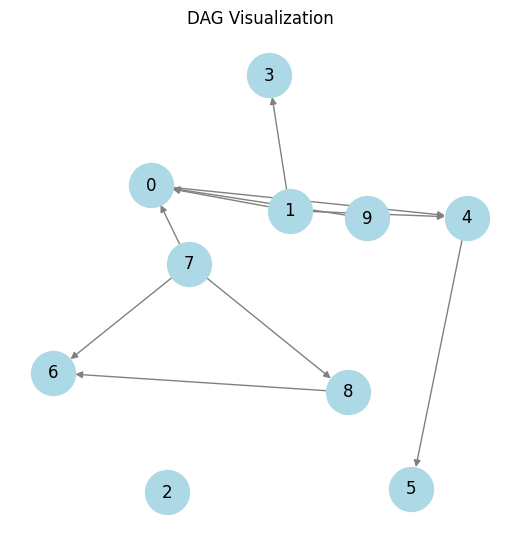

In [118]:
visualize_dag(csv2)

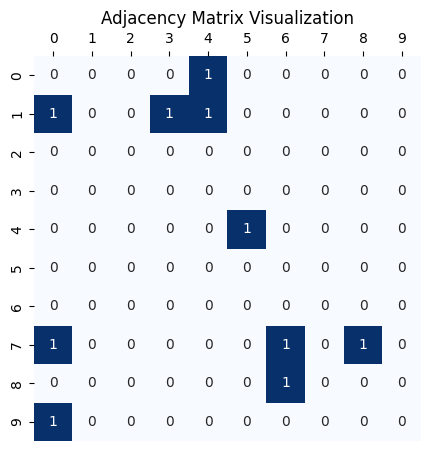

In [113]:
visualize_matrix(csv2)

In [119]:
df = np.loadtxt(csv2, delimiter=',')
df

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [120]:
ndarray = np.loadtxt(csv2, delimiter=',')
ndarray

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [121]:
tensor1 = torch.from_numpy(ndarray)

In [122]:
tensor1

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=torch.float64)

In [124]:
tensor1.size()

torch.Size([10, 10])

In [123]:
num_nodes = tensor1.size(0)
num_nodes

10

In [129]:
edge_index = torch.nonzero(tensor1, as_tuple=False).t().contiguous()
edge_index

tensor([[0, 1, 1, 1, 4, 7, 7, 7, 8, 9],
        [4, 0, 3, 4, 5, 0, 6, 8, 6, 0]])

In [130]:
edge_label = torch.ones(edge_index.size(1))
edge_label

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [131]:
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
edge_index

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
         3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8, 9, 2, 3, 4, 5, 6, 7, 8, 9, 3, 4, 5, 6, 7, 8, 9,
         4, 5, 6, 7, 8, 9, 5, 6, 7, 8, 9, 6, 7, 8, 9, 7, 8, 9, 8, 9, 9]])

In [135]:
edge_index.size()

torch.Size([2, 45])

In [132]:
edge_exist = torch.nonzero(tensor1, as_tuple=False).t().contiguous()
edge_exist

tensor([[0, 1, 1, 1, 4, 7, 7, 7, 8, 9],
        [4, 0, 3, 4, 5, 0, 6, 8, 6, 0]])

In [134]:
# 존재하는 엣지에 대해 레이블을 1로 설정
edge_label = torch.zeros(edge_index.size(1))  # 모든 엣지에 대해 0으로 초기화
# edge_exist와 일치하는 경우 1, 반대 방향이면 -1, 없으면 0
for i, edge in enumerate(edge_index.t()):
    # 순방향 엣지 존재 여부 확인
    if (edge == edge_exist.t()).all(1).any():
        edge_label[i] = 1
    # 역방향 엣지 존재 여부 확인
    elif (edge.flip(0) == edge_exist.t()).all(1).any():
        edge_label[i] = -1
edge_label

tensor([-1.,  0.,  0.,  1.,  0.,  0., -1.,  0., -1.,  0.,  1.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0.,
         1.,  0.,  0.])

In [5]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import feature_extract as fe
import features as ft
import os

def create_data(x_path, adj_path):
    adj_array = np.loadtxt(adj_path, delimiter=',')
    true_adj = torch.from_numpy(adj_array)
    num_nodes = true_adj.size(0)

    x_pd = pd.read_csv(x_path)
    node_features = torch.from_numpy(fe.extract_node_features(x_pd))
    edge_features = torch.from_numpy(fe.extract_edge_features(x_pd))

    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    edge_exist = torch.nonzero(true_adj, as_tuple=False).t().contiguous()
    edge_label = torch.zeros(edge_index.size(1)) 
    for i, edge in enumerate(edge_index.t()):
        if (edge == edge_exist.t()).all(1).any():
            edge_label[i] = 1
        elif (edge.flip(0) == edge_exist.t()).all(1).any():
            edge_label[i] = -1
    
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=edge_label, num_nodes=num_nodes)
    return data

In [6]:
import os

dir_path = '/home/jina/reprod/data/train'

data_list = []
for folder in os.listdir(dir_path):
    folder_path = os.path.join(dir_path, folder)
    print(folder_path)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.startswith('B_true_'):
                adj_path = os.path.join(folder_path, file)
            elif file.startswith('X_'):
                x_path = os.path.join(folder_path, file)
        data = create_data(x_path, adj_path)
        data_list.append(data)

/home/jina/reprod/data/train/003


/home/jina/reprod/data/train/002
/home/jina/reprod/data/train/001


In [7]:
data_list

[Data(x=[20, 9], edge_index=[2, 190], edge_attr=[190, 25], y=[190], num_nodes=20),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10)]

In [8]:
from torch_geometric.data import DataLoader

load_data = DataLoader(data_list, batch_size=32)

/home/jina/anaconda3/envs/jina_env_reprod/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
data_list

[Data(x=[20, 9], edge_index=[2, 190], edge_attr=[190, 25], y=[190], num_nodes=20),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10)]

In [7]:
s = next(iter(load_data))

In [8]:
s

DataBatch(x=[40, 9], edge_index=[2, 280], edge_attr=[280, 25], y=[280], num_nodes=40, batch=[40], ptr=[4])

tensor([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1., -1.,  0.,
        -1., -1.,  0.,  0.,  0.,  0., -1., -1., -1., -1.,  0., -1., -1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0., -1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0., -1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  

In [1]:
import numpy as np
import torch
import torch.nn as nn

import layers
from layers import MeanAggregator, LSTMAggregator, MaxPoolAggregator, MeanPoolAggregator

class GraphSAGE(nn.Module):

    def __init__(self, input_dim, hidden_dims, output_dim,
                 agg_class=MaxPoolAggregator, dropout=0.5, num_samples=25,
                 device='cpu'):
        super(GraphSAGE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.agg_class = agg_class
        self.num_samples = num_samples
        self.device = device
        self.num_layers = len(hidden_dims) + 1

        self.aggregators = nn.ModuleList([agg_class(input_dim, input_dim, device)])
        self.aggregators.extend([agg_class(dim, dim, device) for dim in hidden_dims])


        c = 3 if agg_class == LSTMAggregator else 2
        self.fcs = nn.ModuleList([nn.Linear(c*input_dim, hidden_dims[0])])
        self.fcs.extend([nn.Linear(c*hidden_dims[i-1], hidden_dims[i]) for i in range(1, len(hidden_dims))])
        self.fcs.extend([nn.Linear(c*hidden_dims[-1], output_dim)])

        self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for hidden_dim in hidden_dims])

        self.dropout = nn.Dropout(dropout)

        self.relu = nn.ReLU()

    def forward(self, features, node_layers, mappings, rows):
        out = features
        for k in range(self.num_layers):
            nodes = node_layers[k+1]
            mapping = mappings[k]
            init_mapped_nodes = np.array([mappings[0][v] for v in nodes], dtype=np.int64)
            cur_rows = rows[init_mapped_nodes]
            aggregate = self.aggregators[k](out, nodes, mapping, cur_rows,
                                            self.num_samples)
            cur_mapped_nodes = np.array([mapping[v] for v in nodes], dtype=np.int64)
            out = torch.cat((out[cur_mapped_nodes, :], aggregate), dim=1)
            out = self.fcs[k](out)
            if k+1 < self.num_layers:
                out = self.relu(out)
                out = self.bns[k](out)
                out = self.dropout(out)
                out = out.div(out.norm(dim=1, keepdim=True)+1e-6)

        return out

In [ ]:
from torch_geometric.data import DataLoader
import dataset as ds

dir_path = '/home/jina/reprod/data/train'

data_list = ds.create_dataset(dir_path)
load_data = DataLoader(data_list, batch_size=32)

In [2]:
load_data

In [3]:
sample = next(iter(load_data))
sample

DataBatch(x=[40, 9], edge_index=[2, 280], edge_attr=[280, 25], y=[280], num_nodes=40, batch=[40], ptr=[4])

In [15]:
num_node_features = sample.x.size(1)
out_channels = sample.y.size(0)

print(num_node_features, out_channels)

9 280


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

# 3. GraphSAGE 모델 정의
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        
        # 첫 번째 GraphSAGE 레이어
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        # 두 번째 GraphSAGE 레이어
        x = self.conv2(x, edge_index)

        # 그래프 수준의 풀링 적용 (여러 그래프의 임베딩을 평균화)
        x = global_mean_pool(x, batch)
        return x

In [27]:
# 4. 모델 및 옵티마이저 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_node_features, 128, num_node_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 5. 학습 함수 정의 (수정됨)
def train():
    model.train()
    total_loss = 0
    for data in load_data:
        print(data.size())
        data = data.to(device)
        # 입력 데이터의 타입을 float으로 변환
        data.x = data.x.float()
        data.y = data.y.float()

        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.binary_cross_entropy_with_logits(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

In [ ]:
for epoch in range(1, 6):
    loss = train()
    # valid_rocauc = evaluate(valid_loader)
    # test_rocauc = evaluate(test_loader)
    # print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Valid ROC-AUC: {valid_rocauc:.4f}, Test ROC-AUC: {test_rocauc:.4f}')
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [35]:
start = sample.edge_index[0, :] # 시작 노드
end = sample.edge_index[1, :] # 끝 노드

In [39]:
start.shape

torch.Size([280])

In [ ]:
sample.x.shape

In [40]:
start_node_features = sample.x[start]
end_node_features = sample.x[end]

In [55]:
start_node_features.shape

torch.Size([280, 9])

In [56]:
end_node_features.shape

torch.Size([280, 9])

In [53]:
edge_features = sample.edge_attr

In [54]:
edge_features.shape

torch.Size([280, 25])

In [59]:
message = torch.cat([start_node_features, end_node_features, edge_features], dim=1)

In [60]:
message.shape

torch.Size([280, 43])

In [75]:
num_nodes = start_node_features.shape[0]  # 전체 노드의 수
message_dim = message.shape[1]  # 메시지의 차원

# 노드 메시지를 저장할 텐서 생성 (노드 개수 x 메시지 차원)
node_messages = torch.zeros((num_nodes, message_dim), device=message.device)

node_messages.shape

torch.Size([280, 43])

In [81]:
index = sample.edge_index.size(1)
index

280

In [73]:
node_messages = torch.zeros((num_nodes, message_dim), device=message.device)

for idx in range(index):
    i = start[idx]
    j = end[idx]
    node_messages[i]

torch.Size([280, 43])

In [117]:
# 각 노드별로 들어오는 메시지를 담을 리스트 생성
node_messages1 = torch.zeros((40, message_dim), device=message.device)

# 각 노드로 들어오는 메시지를 node_message_list에 저장 (start 기준)
for i in range(start.shape[0]):
    # start 노드에 메시지를 추가
    node_messages1[start[i].item()] += message[i]

    # end 노드에도 메시지를 추가 (양방향 연결 고려)
    node_messages1[end[i].item()] += message[i]
    # if i >= 270:
    #     print(start[i].item(), end[i].item())
    #     print(message[i])
        # print(node_messages[])
node_messages1

tensor([[ 56.1493, -72.7926,  24.4362,  ...,   8.9245,   6.9314,  10.2602],
        [ 45.4417, -47.4893,  25.9945,  ...,  18.9930,   5.9023,   9.2600],
        [ 52.1472, -45.4401,  26.7158,  ...,   5.3072,   5.6097,  13.8749],
        ...,
        [ 26.8234, -49.6252,  12.4729,  ...,   1.8710,   2.2746,   3.3623],
        [ 21.3859, -63.6680,  12.3998,  ...,   4.3393,   1.3530,   8.3563],
        [ 21.3859, -63.6680,  12.3998,  ...,   3.9988,   1.3722,   2.7344]])

In [115]:
# 각 노드별로 들어오는 메시지를 담을 텐서 생성
node_messages = torch.zeros((num_nodes, message_dim), device=message.device)

# 메시지를 start 노드에 더함
node_messages.index_add_(0, start, message.float())

# 메시지를 end 노드에 더함 (양방향 연결)
node_messages.index_add_(0, end, message.float())

tensor([[ 56.1493, -72.7926,  24.4362,  ...,   8.9245,   6.9314,  10.2602],
        [ 45.4417, -47.4893,  25.9945,  ...,  18.9930,   5.9023,   9.2600],
        [ 52.1472, -45.4401,  26.7158,  ...,   5.3072,   5.6097,  13.8749],
        ...,
        [ 26.8234, -49.6252,  12.4729,  ...,   1.8710,   2.2746,   3.3623],
        [ 21.3859, -63.6680,  12.3998,  ...,   4.3393,   1.3530,   8.3563],
        [ 21.3859, -63.6680,  12.3998,  ...,   3.9988,   1.3722,   2.7344]])

In [96]:
node_messages

tensor(0)

In [103]:
start.shape[0]

280

In [105]:
start

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11,
        12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
        15, 15, 15, 15, 16, 16, 16, 17, 17, 18, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23,
        23, 23, 23, 23, 24, 24, 24, 24, 

In [106]:
end

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
         4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  5,  6,
         7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  6,  7,  8,  9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  9, 10,
        11, 12, 13, 14, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 11, 12, 13, 14, 15, 16, 17, 18, 19, 12, 13, 14, 15, 16, 17, 18, 19,
        13, 14, 15, 16, 17, 18, 19, 14, 15, 16, 17, 18, 19, 15, 16, 17, 18, 19,
        16, 17, 18, 19, 17, 18, 19, 18, 19, 19, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 22, 23, 24, 25, 26, 27, 28, 29, 23, 24, 25, 26, 27, 28, 29, 24, 25,
        26, 27, 28, 29, 25, 26, 27, 28, 

In [109]:
message.shape

torch.Size([280, 43])

In [111]:
num_nodes

280

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool

# 3. GraphSAGE 모델 정의
# class GraphSAGE(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels):
#         super(GraphSAGE, self).__init__()
#         self.conv1 = SAGEConv(in_channels, hidden_channels)
#         self.conv2 = SAGEConv(hidden_channels, out_channels)

class GraphSAGE(nn.Module):

    def __init__(self, input_dim, hidden_dims, output_dim,
                 agg_class=MaxPoolAggregator, dropout=0.5, num_samples=25,
                 device='cpu'):
        """
        Parameters
        ----------
        input_dim : int
            Dimension of input node features.
        hidden_dims : list of ints
            Dimension of hidden layers. Must be non empty.
        output_dim : int
            Dimension of output node features.
        agg_class : An aggregator class.
            Aggregator. One of the aggregator classes imported at the top of
            this module. Default: MaxPoolAggregator.
        dropout : float
            Dropout rate. Default: 0.5.
        num_samples : int
            Number of neighbors to sample while aggregating. Default: 25.
        device : str
            'cpu' or 'cuda:0'. Default: 'cpu'.
        """
        super(GraphSAGE, self).__init__()


        # self.input_dim = input_dim
        # self.hidden_dims = hidden_dims
        # self.output_dim = output_dim
        # self.agg_class = agg_class
        # self.num_samples = num_samples
        # self.device = device
        # self.num_layers = len(hidden_dims) + 1

        # self.aggregators = nn.ModuleList([agg_class(input_dim, input_dim, device)])
        # self.aggregators.extend([agg_class(dim, dim, device) for dim in hidden_dims])


        # c = 3 if agg_class == LSTMAggregator else 2
        self.fcs = nn.ModuleList([nn.Linear(c*input_dim, hidden_dims[0])])
        # self.fcs.extend([nn.Linear(c*hidden_dims[i-1], hidden_dims[i]) for i in range(1, len(hidden_dims))])
        # self.fcs.extend([nn.Linear(c*hidden_dims[-1], output_dim)])

        # self.bns = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for hidden_dim in hidden_dims])

        # self.dropout = nn.Dropout(dropout)

        self.relu = nn.ReLU()
        self.conv = SAGEConv()


    def forward(self, data, num_neighbor, batch):
        x = data.x
        edge_index = data.edge_index
        edge_features = data.edge_attr
        num_nodes = data.num_nodes

        m_v = self.conv(x, edge_index, edge_features, num_nodes, num_neighbor)
        h_v = self.relu(m_v)
        


        # # 첫 번째 GraphSAGE 레이어
        # x = self.conv1(x, edge_index)
        # x = F.relu(x)
        # x = F.dropout(x, training=self.training)

        # # 두 번째 GraphSAGE 레이어
        # x = self.conv2(x, edge_index)

        # # 그래프 수준의 풀링 적용 (여러 그래프의 임베딩을 평균화)
        # x = global_mean_pool(x, batch)
        return x

In [5]:
class CustomSAGEConv(SAGEConv):
    def __init__(self, node_dim, edge_dim, aggr='mean', normalize=False, root_weight=True, bias=True):
        super(CustomSAGEConv, self).__init__(node_dim, edge_dim)
        self.relu = nn.ReLU()
        self.aggr = aggr
        self.root_weight = root_weight
        self.bias = bias
        if self.root_weight:
            weight_dim = 3*node_dim + edge_dim
        else:
            weight_dim = 2*node_dim + edge_dim
        self.lin = nn.Linear(weight_dim, node_dim, bias=self.bias)
        nn.init.xavier_normal_(self.lin.weight)


    def forward(self, x, edge_index, edge_features, num_nodes, num_neighbor=None):
        v = edge_index[0, :]
        u = edge_index[1, :]
        v_node_features = x[v]
        u_node_features = x[u]

        message = torch.cat([v_node_features, u_node_features, edge_features], dim=-1)
        message_dim = message.size(1)
        node_messages = torch.zeros((num_nodes, message_dim))
        # num_neighbor 만큼 aggregate하기....(일단 전체 노드에 대해서)
        if self.aggr == 'mean':
            node_messages.index_add(0, v, message.float())
            node_messages.index_add(0, u, message.float())
            node_messages /= num_nodes
        if self.root_weight:
            out = torch.cat([x, node_messages], dim=-1)
        else:
            out = node_messages
        out = self.lin(out.float())

        # # 선택적 정규화 적용
        # if self.normalize:
        #     out = F.normalize(out, p=2, dim=-1)
        
        return out


In [43]:
nf = sample.x.size(1)
ef = sample.edge_attr.size(1)

In [44]:
conv = CustomSAGEConv(nf, ef)
y = conv(sample.x, sample.edge_index, sample.edge_attr, sample.num_nodes)

In [45]:
y.shape

torch.Size([40, 9])

In [13]:
mlp = nn.Sequential(nn.Linear(2*nf, 64), nn.ReLU(), nn.Linear(64, 3))

In [14]:
v = sample.edge_index[0, :]
u = sample.edge_index[1, :]
preds = []
v_node_embedding = y[v]  # v번째 노드 임베딩
u_node_embedding = y[u]  # u번째 노드 임베딩

# 두 노드의 임베딩을 concat하고 MLP에 입력
pair_embedding = torch.cat([v_node_embedding, u_node_embedding], dim=-1)
print(pair_embedding.shape)
pred = mlp(pair_embedding)  # MLP를 통해 예측 (3 클래스 분류: -1, 0, 1)
print(pred.shape)

torch.Size([280, 18])
torch.Size([280, 3])


In [7]:
class GraphSAGE(nn.Module):

    def __init__(self, node_dim, edge_dim, num_layers,
                 agg_class='mean', dropout=0.3, num_samples=25,
                 device='cpu'):
        """
        Parameters
        ----------
        input_dim : int
            Dimension of input node features.
        hidden_dims : list of ints
            Dimension of hidden layers. Must be non empty.
        output_dim : int
            Dimension of output node features.
        agg_class : An aggregator class.
            Aggregator. One of the aggregator classes imported at the top of
            this module. Default: MaxPoolAggregator.
        dropout : float
            Dropout rate. Default: 0.5.
        num_samples : int
            Number of neighbors to sample while aggregating. Default: 25.
        device : str
            'cpu' or 'cuda:0'. Default: 'cpu'.
        """
        super(GraphSAGE, self).__init__()

        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.agg_class = agg_class
        self.num_samples = num_samples
        self.device = device
        self.num_layers = num_layers

        self.conv = CustomSAGEConv(node_dim, edge_dim)
        self.mlp = nn.Sequential(nn.Linear(2*node_dim, 64), nn.ReLU(), nn.Linear(64, 3))

        self.bns = nn.BatchNorm1d(node_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, data):
        """
        Parameters
        ----------
        features : torch.Tensor
            An (n' x input_dim) tensor of input node features.
        node_layers : list of numpy array
            node_layers[i] is an array of the nodes in the ith layer of the
            computation graph.
        mappings : list of dictionary
            mappings[i] is a dictionary mapping node v (labelled 0 to |V|-1)
            in node_layers[i] to its position in node_layers[i]. For example,
            if node_layers[i] = [2,5], then mappings[i][2] = 0 and
            mappings[i][5] = 1.
        rows : numpy array
            rows[i] is an array of neighbors of node i.

        Returns
        -------
        out : torch.Tensor
            An (len(node_layers[-1]) x output_dim) tensor of output node features.
        """
        x = data.x
        edge_index = data.edge_index
        edge_features = data.edge_attr
        num_nodes = data.num_nodes

        for k in range(self.num_layers):
            x = self.conv(x, edge_index, edge_features, num_nodes)
            x = self.dropout(x)
            x = self.relu(x)
            # print(x.shape)
        # print(x.shape)
        v = edge_index[0, :]
        u = edge_index[1, :]
        v_node_embedding = x[v]  
        u_node_embedding = x[u]  

        pair_embedding = torch.cat([v_node_embedding, u_node_embedding], dim=-1)
        pred = self.mlp(pair_embedding)  # MLP를 통해 예측 (3 클래스 분류: -1, 0, 1)

        return pred

In [48]:
model = GraphSAGE(nf, ef, num_layers=3)

In [49]:
print(nf, ef)

9 25


In [50]:
pred = model(sample)

In [51]:
pred.shape

torch.Size([280, 3])

In [ ]:
pred

In [53]:
sample.y.shape

torch.Size([280])

In [54]:
criterion = nn.CrossEntropyLoss() 
loss = criterion(pred, sample.y.long())

In [55]:
_, preds = torch.max(pred, 1)

In [56]:
torch.sum(preds == sample.y.long())

tensor(192)

In [3]:
import data_generation as dg

dg.generate_data(n=500, d=20, s0=20, graph_type='SF', linear_sem_type='gauss', nonlinear_sem_type='mlp', type='nonlinear', save_dir='/home/jina/reprod/data/new')

In [8]:
from torch_geometric.data import Batch
def collate_fn(batch):
    return Batch.from_data_list(batch)

In [9]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
import dataset
# from model import GraphSAGE


train_path = '/home/jina/reprod/data/valid'
batch_size = 32
epochs = 100
num_layers = 3
lr = 0.001

train_data = dataset.create_dataset(train_path)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)


    

KeyboardInterrupt: 

In [5]:
train_data

[Data(x=[20, 9], edge_index=[2, 190], edge_attr=[190, 54], y=[190], num_nodes=20),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 54], y=[45], num_nodes=10)]

In [173]:
train_data.pop()

Data(x=[50, 9], edge_index=[2, 1225], edge_attr=[1225, 24], y=[1225], num_nodes=50)

In [10]:
train_data

[Data(x=[20, 9], edge_index=[2, 190], edge_attr=[190, 24], y=[190], num_nodes=20),
 Data(x=[20, 9], edge_index=[2, 190], edge_attr=[190, 25], y=[190], num_nodes=20),
 Data(x=[50, 9], edge_index=[2, 1225], edge_attr=[1225, 25], y=[1225], num_nodes=50),
 Data(x=[100, 9], edge_index=[2, 4950], edge_attr=[4950, 25], y=[4950], num_nodes=100),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10),
 Data(x=[100, 9], edge_index=[2, 4950], edge_attr=[4950, 25], y=[4950], num_nodes=100),
 Data(x=[20, 9], edge_index=[2, 190], edge_attr=[190, 25], y=[190], num_nodes=20),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10),
 Data(x=[50, 9], edge_index=[2, 1225], edge_attr=[1225, 24], y=[1225], num_nodes=50),
 Data(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10)]

In [ ]:
from torch_geometric.loader import DataLoader, NodeLoader, LinkLoader

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# train_link = LinkLoader(train_data, batch_size=batch_size, shuffle=True)
# train_node = NodeLoader(train_data, batch_size=batch_size, shuffle=True)

In [191]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

node_dim = train_data[0].x.size(1)
edge_dim = train_data[0].edge_attr.size(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(node_dim, edge_dim, num_layers=num_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() 

# model.train()
for epoch in range(epochs):
    running_loss = 0
    running_acc = 0
    total_samples = 0

    for data in train_loader:
        # print(data.x.size())
        # print(data.edge_attr.size())
        # print(data.edge_index.size())
        node_dim = data.x.size(1)
        edge_dim = data.edge_attr.size(1)
        # print(node_dim, edge_dim)
        model = GraphSAGE(node_dim, edge_dim, num_layers=num_layers).to(device)
        
        model.train()
        data = data.to(device)
        
        data.x = data.x.float()
        data.y = data.y.long()

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, data.y)
        _, preds = torch.max(logits, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.y.size(0)
        print(torch.sum(preds == data.y), data.y.size(0))
        running_acc += torch.sum(preds == data.y).item()
        total_samples += data.y.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_acc / total_samples
    print(f'epoch: {epoch+1}, Train loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f}')

tensor(401) 11405
epoch: 1, Train loss: 1.157, acc: 0.035
tensor(396) 11405
epoch: 2, Train loss: 1.216, acc: 0.035
tensor(396) 11405
epoch: 3, Train loss: 1.258, acc: 0.035
tensor(1609) 11405
epoch: 4, Train loss: 1.030, acc: 0.141
tensor(399) 11405
epoch: 5, Train loss: 1.192, acc: 0.035
tensor(975) 11405
epoch: 6, Train loss: 1.131, acc: 0.085
tensor(10737) 11405
epoch: 7, Train loss: 0.934, acc: 0.941
tensor(8678) 11405
epoch: 8, Train loss: 1.045, acc: 0.761
tensor(2053) 11405
epoch: 9, Train loss: 1.107, acc: 0.180
tensor(1655) 11405
epoch: 10, Train loss: 1.076, acc: 0.145
tensor(9685) 11405
epoch: 11, Train loss: 1.021, acc: 0.849
tensor(480) 11405
epoch: 12, Train loss: 1.112, acc: 0.042
tensor(7208) 11405
epoch: 13, Train loss: 1.072, acc: 0.632
tensor(10529) 11405
epoch: 14, Train loss: 1.044, acc: 0.923
tensor(7559) 11405
epoch: 15, Train loss: 1.068, acc: 0.663
tensor(10210) 11405
epoch: 16, Train loss: 0.996, acc: 0.895
tensor(1825) 11405
epoch: 17, Train loss: 1.143, acc

In [28]:
train_data

NameError: name 'train_data' is not defined

In [186]:
train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

In [187]:
for data in train_loader:
    print(data)

DataBatch(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10, batch=[10], ptr=[2])
DataBatch(x=[10, 9], edge_index=[2, 45], edge_attr=[45, 25], y=[45], num_nodes=10, batch=[10], ptr=[2])
DataBatch(x=[100, 9], edge_index=[2, 4950], edge_attr=[4950, 25], y=[4950], num_nodes=100, batch=[100], ptr=[2])
DataBatch(x=[50, 9], edge_index=[2, 1225], edge_attr=[1225, 25], y=[1225], num_nodes=50, batch=[50], ptr=[2])
DataBatch(x=[100, 9], edge_index=[2, 4950], edge_attr=[4950, 25], y=[4950], num_nodes=100, batch=[100], ptr=[2])
DataBatch(x=[20, 9], edge_index=[2, 190], edge_attr=[190, 25], y=[190], num_nodes=20, batch=[20], ptr=[2])


In [1]:
import torch
torch.cuda.is_available()

True

In [23]:
import features as ft
from sklearn.base import BaseEstimator
import numpy as np
import pandas as pd
import operator
import math
import multiprocessing as mp
from multiprocessing import Pool
import itertools



class SimpleTransform(BaseEstimator):
    def __init__(self, transformer, *args):
        self.transformer = transformer
        self.args = args

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X)

    def transform(self, X, y=None):
        if self.args:
            return np.array([self.transformer(X, *self.args)], ndmin=2).T
        # return np.array([self.transformer(x) for x in X], ndmin=2).T
        else:
            return np.array([self.transformer(X)], ndmin=2).T


class MultiColumnTransform(BaseEstimator):
    def __init__(self, transformer, *args):
        self.transformer = transformer
        self.args = args

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X, y=None):
        return self.transform(X)

    def transform(self, X, y=None):
        X = X.to_numpy()
        if self.args:
            return np.array([self.transformer(column, *self.args) for column in X.T], ndmin=2).T
        else:
            # return X.apply(self.transformer, axis=0).to_numpy().T
            return np.array([self.transformer(column) for column in X.T], ndmin=2).T


class PairColumnTransform(BaseEstimator):
    def __init__(self, transformer, *args):
        self.transformer = transformer
        self.args = args

    def fit(self, X, y=None):
        return self

    def fit_transform(self, X1, X2, y=None):
        return self.transform(X1, X2)

    def transform(self, X1, X2, y=None):
        if self.args:
            # return np.array([self.transformer(c1, c2, *self.args) for c1, c2 in zip(X1.T, X2.T)], ndmin=2).T
            return np.array(self.transformer(X1.T, X2.T, *self.args), ndmin=2).T
        else:
            # return np.array([self.transformer(c1, c2) for c1, c2 in zip(X1.T, X2.T)], ndmin=2).T
            return np.array(self.transformer(X1.T, X2.T), ndmin=2).T


node_features = [
    ('Max', MultiColumnTransform(np.max)),
    ('Min', MultiColumnTransform(np.min)),
    ('Normalized Entropy Baseline', MultiColumnTransform(ft.normalized_entropy_baseline)),
    ('Normalized Entropy', MultiColumnTransform(ft.normalized_entropy)),
    ('Uniform Divergence', MultiColumnTransform(ft.uniform_divergence)),
    ('Skewness', MultiColumnTransform(ft.normalized_skewness)),
    ('Kurtosis', MultiColumnTransform(ft.normalized_kurtosis)),
    ('weighted_mean', MultiColumnTransform(ft.weighted_mean)),
    ('weighted_std', MultiColumnTransform(ft.weighted_std)),
    ('Interquartile Range', MultiColumnTransform(lambda x: np.percentile(x, 75) - np.percentile(x, 25))),
    # ('Median', MultiColumnTransform(np.median)),
    ('Coefficient of Variation', MultiColumnTransform(lambda x: np.std(x) / np.mean(x) if np.mean(x) != 0 else 0)),
    # ('Shannon Diversity Index', MultiColumnTransform(lambda x: -np.sum(x * np.log(x)) if np.all(x > 0) else 0)),
]


edge_features = [
    ('Sub_Numerical', PairColumnTransform(operator.sub), None),
    ('Sub_Normalized Entropy Baseline', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy_baseline)),
    ('Sub_Normalized Entropy', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy)),
    ('Sub_Normalized Entropy5', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy, 5)),
    ('Sub_Normalized Entropy5', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_entropy, 10)),
    ('IGCI', PairColumnTransform(ft.igci), None),
    ('Sub_Uniform Divergence', PairColumnTransform(operator.sub), SimpleTransform(ft.uniform_divergence)),
    # ('Sub_Uniform Divergence5', PairColumnTransform(operator.sub), SimpleTransform(ft.uniform_divergence, 5)),
    ('Polyfit', PairColumnTransform(ft.fit), None),
    ('Polyfit Error', PairColumnTransform(ft.fit_error), None),
    ('Polyfit Error3', PairColumnTransform(ft.fit_error, 3), None),
    ('Polyfit Error5', PairColumnTransform(ft.fit_error, 5), None),
    ('fit_noise_entropy', PairColumnTransform(ft.fit_noise_entropy), None),
    ('fit_noise_entropy55', PairColumnTransform(ft.fit_noise_entropy, 5, 5), None),
    ('fit_noise_entropy43', PairColumnTransform(ft.fit_noise_entropy, 4, 3), None),
    ('fit_noise_skewness', PairColumnTransform(ft.fit_noise_skewness), None),
    ('fit_noise_skewness55', PairColumnTransform(ft.fit_noise_skewness, 5, 5), None),
    ('fit_noise_kurtosis', PairColumnTransform(ft.fit_noise_kurtosis), None),
    ('fit_noise_kurtosis55', PairColumnTransform(ft.fit_noise_kurtosis, 5, 5), None),
    ('Conditional Distribution Similarity', PairColumnTransform(ft.conditional_distribution_similarity), None),
    ('Conditional Distribution Similarity35', PairColumnTransform(ft.conditional_distribution_similarity, 3, 5), None),
    ('Conditional Distribution Similarity53', PairColumnTransform(ft.conditional_distribution_similarity, 5, 3), None),
    ('normalized_moment23', PairColumnTransform(ft.normalized_moment, 2, 3), None),
    ('normalized_moment33', PairColumnTransform(ft.normalized_moment, 3, 3), None),
    ('Moment21', PairColumnTransform(ft.moment21), None),
    ('Moment22', PairColumnTransform(ft.moment22), None),
    ('Moment31', PairColumnTransform(ft.moment31), None),
    ('Sub_Skewness', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_skewness)),
    ('Sub_Kurtosis', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_kurtosis)),
    ('Sub_discrete_entropy', PairColumnTransform(operator.sub), SimpleTransform(ft.discrete_entropy)),
    ('Sub_discrete_entropy53', PairColumnTransform(operator.sub), SimpleTransform(ft.discrete_entropy, 5, 3)),
    ('Sub_discrete_entropy34', PairColumnTransform(operator.sub), SimpleTransform(ft.discrete_entropy, 3, 4)),
    ('Sub_mormalized_discrete_entropy', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_discrete_entropy)),
    ('Sub_mormalized_discrete_entropy53', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_discrete_entropy, 5, 3)),
    ('Sub_mormalized_discrete_entropy34', PairColumnTransform(operator.sub), SimpleTransform(ft.normalized_discrete_entropy, 3, 4)),
    ('Normalized Error Probability', PairColumnTransform(ft.normalized_error_probability), None),
    ('Normalized Error Probability53', PairColumnTransform(ft.normalized_error_probability, 5, 3), None),
    ('Normalized Error Probability34', PairColumnTransform(ft.normalized_error_probability, 3, 4), None),
    ('Discrete_joint_entropy', PairColumnTransform(ft.discrete_joint_entropy), None),
    ('Discrete_joint_entropy53', PairColumnTransform(ft.discrete_joint_entropy, 5, 3), None),
    ('Discrete_joint_entropy34', PairColumnTransform(ft.discrete_joint_entropy, 3, 4), None),
    ('Normalized Discrete joint entropy', PairColumnTransform(ft.normalized_discrete_joint_entropy), None),
    ('Normalized Discrete joint entropy53', PairColumnTransform(ft.normalized_discrete_joint_entropy, 5, 3), None),
    ('Normalized Discrete joint entropy34', PairColumnTransform(ft.normalized_discrete_joint_entropy, 3, 4), None),
    ('Discrete conditional entropy', PairColumnTransform(ft.discrete_conditional_entropy), None),
    ('adjusted_mutual_information', PairColumnTransform(ft.adjusted_mutual_information), None),
    ('adjusted_mutual_information53', PairColumnTransform(ft.adjusted_mutual_information, 5, 3), None),
    ('adjusted_mutual_information34', PairColumnTransform(ft.adjusted_mutual_information, 3, 4), None),
    ('discrete_mutual_information', PairColumnTransform(ft.discrete_mutual_information), None),
    ('correlation', PairColumnTransform(ft.correlation), None),
    ('normalized_hsic', PairColumnTransform(ft.normalized_hsic), None),

]


def process_node(args):
    extractor, X = args
    return extractor.transform(X)


def process_pair(args):
    n1, n2, X, features = args
    result = []

    df1 = X.iloc[:, n1].to_numpy()
    df2 = X.iloc[:, n2].to_numpy()

    for name, extractor, operation in features:
        if operation:
            df1_transformed = operation.transform(df1)
            df2_transformed = operation.transform(df2)
        else:
            df1_transformed = df1
            df2_transformed = df2

        m = extractor.transform(df1_transformed, df2_transformed)  # 순서: n1 -> n2
        n = extractor.transform(df2_transformed, df1_transformed)  # 순서: n2 -> n1

        y = np.mean(np.abs(m))
        z = np.mean(np.abs(n))

        result.append((y, z))

    return result


def extract_node_features(X, features=node_features, y=None, n_jobs=-1):
    if n_jobs != 1:
        pool = Pool(n_jobs if n_jobs != -1 else None)
        pmap = pool.map
    else:
        pmap = map
    # with mp.Pool(processes=mp.cpu_count()) as pool:

    args = [(extractor, X) for name, extractor in features]
    results = pmap(process_node, args)

    node_data = np.column_stack(results)
    return node_data


def extract_edge_features(X, features=edge_features, y=None, n_jobs=-1):
    if n_jobs != 1:
        pool = Pool(n_jobs if n_jobs != -1 else None)
        pmap = pool.map
    else:
        pmap = map
    # with mp.Pool(processes=mp.cpu_count()) as pool:

    nodes = [n for n in range(len(X.columns))]
    pairs = list(itertools.combinations(nodes, 2)) # node의 컬럼인덱스 혹은 컬럼명

    args = [(n1, n2, X, features) for n1, n2 in pairs]
    results = pmap(process_pair, args)

    # 결과를 병합
    pair_values1 = []
    pair_values2 = []

    for result in results:
        for y, z in result:
            pair_values1.append(y)
            pair_values2.append(z)

    edge_data = np.array([pair_values1, pair_values2]).T

    return edge_data


In [37]:
edge_Data = extract_edge_features(pd.read_csv(x_csv))

Process SpawnPoolWorker-1771:
Process SpawnPoolWorker-1772:
Traceback (most recent call last):
  File "/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'process_pair' on <module '__main__' (built-in)>
Process SpawnPoolWorker-1774:
Traceback (most recent call last):
  File "/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/multiprocessing/process.py", line

KeyboardInterrupt: 

In [38]:
import feature_extract as fe

edge_data = fe.extract_edge_features(pd.read_csv(x_csv))

In [20]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import os
import torch.multiprocessing as mp


def process_folder(folder_path):
    # folder_path, dir_path = args
    x_path, adj_path = None, None
    for file in os.listdir(folder_path):
        if file.startswith('B_true_'):
            adj_path = os.path.join(folder_path, file)
        elif file.startswith('X_'):
            x_path = os.path.join(folder_path, file)
    if x_path and adj_path:
        return create_data(x_path, adj_path)


def create_data(x_path, adj_path):
    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    adj_array = np.loadtxt(adj_path, delimiter=',')
    true_adj = torch.from_numpy(adj_array)
    num_nodes = true_adj.size(0)

    x_pd = pd.read_csv(x_path)
    # node_features = torch.from_numpy(fe.extract_node_features(x_pd)).to(device)
    # edge_features = torch.from_numpy(fe.extract_edge_features(x_pd)).to(device)
    # node_features = torch.from_numpy(np.nan_to_num(fe.extract_node_features(x_pd), nan=0.0)).to(device)
    # edge_features = torch.from_numpy(np.nan_to_num(fe.extract_edge_features(x_pd), nan=0.0)).to(device)
    node_features = torch.from_numpy(np.nan_to_num(extract_node_features(x_pd, n_jobs=2), nan=0.0))
    edge_features = torch.from_numpy(np.nan_to_num(extract_edge_features(x_pd, n_jobs=2), nan=0.0))


    edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
    edge_exist = torch.nonzero(true_adj, as_tuple=False).t().contiguous()
    edge_label = torch.zeros(edge_index.size(1)) 

    for i, edge in enumerate(edge_index.t()):
        if (edge == edge_exist.t()).all(1).any():
            edge_label[i] = 1
        elif (edge.flip(0) == edge_exist.t()).all(1).any():
            edge_label[i] = 2
    
    data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=edge_label, num_nodes=num_nodes)
    return data

    
def create_dataset(dir_path):
    data_list = []
    folders = [os.path.join(dir_path, folder) for folder in os.listdir(dir_path) 
               if os.path.isdir(os.path.join(dir_path, folder))]
    
    with mp.Pool(processes=mp.cpu_count()) as pool:
        data_list = pool.map(process_folder, [folder for folder in folders])

    data_list = [data for data in data_list if data is not None]

    return data_list
    
# # 'if __name__ == "__main__"' 블록 안에 코드를 넣어야 합니다.
# if __name__ == '__main__':
#     try:
#         mp.set_start_method('spawn', force=False)  # 'spawn' 방식을 설정
#     except RuntimeError:
#         pass  # 이미 설정된 경우 오류 무시

#     train_path = '/home/jina/reprod/data/new'
#     train_data = create_dataset(train_path)


In [2]:
import dataset
train_path = '/home/jina/reprod/data/new'
train_data1 = dataset.create_dataset(train_path)

In [32]:
b_csv = '/home/jina/reprod/data/new/001/B_true_ER_gauss.csv'
x_csv = '/home/jina/reprod/data/new/001/X_ER_gauss.csv'

In [34]:
sample = dataset.create_data(b_csv, x_csv)

/home/jina/reprod/features.py:185: RuntimeWarning: invalid value encountered in scalar divide
  e = e/np.log(n)
/home/jina/reprod/features.py:158: RuntimeWarning: invalid value encountered in scalar divide
  e = e/np.log(nx*ny)
/home/jina/reprod/features.py:418: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r = pearsonr(x, y)[0]
/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jina/anaconda3/envs/jina_gnn/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [11]:
[sample]

[Data(x=[10, 11], edge_index=[2, 124750], edge_attr=[45, 100], y=[124750], num_nodes=500)]

In [41]:
import pickle

pk = '/home/jina/reprod/data/pickle/new_1'
with open(pk, 'rb') as f:
    train_data = pickle.load(f)

In [42]:
train_data

[Data(x=[20, 11], edge_index=[2, 190], edge_attr=[190, 100], y=[190], num_nodes=20),
 Data(x=[10, 11], edge_index=[2, 45], edge_attr=[45, 100], y=[45], num_nodes=10)]

In [21]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
import feature_extract as fe
import features as ft
import os
import torch.multiprocessing as mp
import pickle
import argparse
from tqdm import tqdm

def create_data(x_path, adj_path, folder_name):
    with tqdm(total=2, desc=f"{folder_name}") as pbar:
        adj_array = np.loadtxt(adj_path, delimiter=',')
        true_adj = torch.from_numpy(adj_array)
        num_nodes = true_adj.size(0)

        x_pd = pd.read_csv(x_path)
        # node_features = torch.from_numpy(fe.extract_node_features(x_pd))
        # edge_features = torch.from_numpy(fe.extract_edge_features(x_pd))
        node_features = torch.from_numpy(np.nan_to_num(extract_node_features(x_pd), nan=0.0))
        pbar.update(1)
        edge_features = torch.from_numpy(np.nan_to_num(extract_edge_features(x_pd), nan=0.0))
        pbar.update(1)

        edge_index = torch.combinations(torch.arange(num_nodes), r=2).t()
        edge_exist = torch.nonzero(true_adj, as_tuple=False).t().contiguous()
        edge_label = torch.zeros(edge_index.size(1)) 
        for i, edge in enumerate(edge_index.t()):
            if (edge == edge_exist.t()).all(1).any():
                edge_label[i] = 1
            elif (edge.flip(0) == edge_exist.t()).all(1).any():
                edge_label[i] = 2
        
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_features, y=edge_label, num_nodes=num_nodes)
    return data


def create_dataset(dir_path):
    data_list = []
    for folder in os.listdir(dir_path):
        folder_path = os.path.join(dir_path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                if file.startswith('B_true_'):
                    adj_path = os.path.join(folder_path, file)
                elif file.startswith('X_'):
                    x_path = os.path.join(folder_path, file)
            data = create_data(x_path, adj_path, folder)
            data_list.append(data)

    return data_list



In [ ]:
new_dir = '/home/jina/reprod/data/valid'
create_dataset(new_dir)

In [1]:
import pickle

pk = '/home/jina/reprod/data/pickle/train_1'
with open(pk, 'rb') as f:
    train_data = pickle.load(f)

In [2]:
pk_v = '/home/jina/reprod/data/pickle/valid_1'
with open(pk_v, 'rb') as f:
    valid_data = pickle.load(f)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class F1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        tn = ((1 - y_true) * (1 - y_pred)).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)
        return 1 - f1.mean()
    

class WeightedF1Loss(nn.Module):
    def __init__(self, classes=3, epsilon=1e-7):
        super().__init__()
        self.classes = classes
        self.epsilon = epsilon

    def forward(self, y_pred, y_true, class_weights=None):
        assert y_pred.ndim == 2
        assert y_true.ndim == 1
        y_true = F.one_hot(y_true, self.classes).to(torch.float32)
        y_pred = F.softmax(y_pred, dim=1)

        tp = (y_true * y_pred).sum(dim=0).to(torch.float32)
        fp = ((1 - y_true) * y_pred).sum(dim=0).to(torch.float32)
        fn = (y_true * (1 - y_pred)).sum(dim=0).to(torch.float32)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * (precision * recall) / (precision + recall + self.epsilon)
        f1 = f1.clamp(min=self.epsilon, max=1 - self.epsilon)

        # Apply class weights if provided
        if class_weights is not None:
            class_weights = class_weights.to(f1.device)
            weighted_f1 = f1 * class_weights
            return 1 - weighted_f1.mean()

        return 1 - f1.mean()


In [11]:
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
import dataset
from model import GraphSAGE
import pickle
import os
from collections import Counter
from sklearn.metrics import f1_score

batch_size = 32
epochs = 30
num_layers = 3
lr = 0.0001

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)

loader_type = {
    "train": train_loader,
    "test": valid_loader
}

node_dim = train_data[0].x.size(1)
edge_dim = train_data[0].edge_attr.size(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
model = GraphSAGE(node_dim, edge_dim, num_layers=num_layers, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() 

best_test_f1 = 0
best_test_acc = 0
best_test_loss = 9999


for epoch in range(epochs):
    all_predictions = []
    all_labels = []

    for mode in ["train", "test"]:
        running_loss = 0
        running_acc = 0
        total_samples = 0

        if mode == 'train':
            model.train()
        elif mode == 'test':
            model.eval()
        
        for data in loader_type[mode]:
        # node_dim = data.x.size(1)
        # edge_dim = data.edge_attr.size(1)
        # # print(node_dim, edge_dim)
        # model = GraphSAGE(node_dim, edge_dim, num_layers=num_layers).to(device)
        # model.train()
            
            data.x = data.x.float()
            data.y = data.y.long()

            class_counts = Counter(data.y.numpy())
            total_count = sum(class_counts.values())
            class_weights = {cls: total_count / count for cls, count in class_counts.items()}
            weights = torch.tensor([class_weights[cls] for cls in range(3)], dtype=torch.float).to(device)

            data = data.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(mode == 'train'):
                logits = model(data)
                # if epoch == 49:
                #     print(logits)
                # loss = nn.CrossEntropyLoss()(logits, data.y)
                # loss = nn.CrossEntropyLoss(weight=weights)(logits, data.y)
                # loss = F1Loss(classes=3)(logits, data.y)
                loss = WeightedF1Loss(classes=3)(logits, data.y, class_weights=weights)
                
                _, preds = torch.max(logits, 1)

                if mode == 'train':
                    loss.backward()
                    optimizer.step()


                all_predictions.extend(preds.cpu().numpy())
                all_labels.extend(data.y.cpu().numpy())

            running_loss += loss.item() * data.y.size(0)
            # print(torch.sum(preds == data.y), data.y.size(0))
            running_acc += torch.sum(preds == data.y).item()
            total_samples += data.y.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_acc / total_samples
        epoch_f1 = f1_score(all_labels, all_predictions, average='macro')
        print(f'epoch: {epoch+1}, {mode} loss: {epoch_loss:.3f}, acc: {epoch_acc:.3f} f1: {epoch_f1:.3f}')

        if mode == 'test' and best_test_f1 < epoch_f1:
            best_test_f1 = epoch_f1

        if mode == 'test' and best_test_acc < epoch_acc:
            best_test_acc = epoch_acc

        if mode == 'test' and best_test_loss > epoch_loss:
            # file_name = f'epoch{epoch+1:04d}_{str(epoch_loss)[:5].replace(".","")}'
            # save_model(model, saved_dir, f'{file_name}.pth')
            best_test_loss = epoch_loss

print("training end!!")
print(f"best f1: {best_test_f1}, best acc: {best_test_acc}, best loss: {best_test_loss}")


epoch: 1, train loss: -0.383, acc: 0.098 f1: 0.080
epoch: 1, test loss: -0.380, acc: 0.043 f1: 0.079
epoch: 2, train loss: -0.394, acc: 0.092 f1: 0.076
epoch: 2, test loss: -0.379, acc: 0.043 f1: 0.074
epoch: 3, train loss: -0.396, acc: 0.101 f1: 0.081
epoch: 3, test loss: -0.378, acc: 0.043 f1: 0.079
epoch: 4, train loss: -0.393, acc: 0.100 f1: 0.080
epoch: 4, test loss: -0.377, acc: 0.043 f1: 0.078
epoch: 5, train loss: -0.414, acc: 0.105 f1: 0.088
epoch: 5, test loss: -0.375, acc: 0.043 f1: 0.086
epoch: 6, train loss: -0.409, acc: 0.117 f1: 0.092
epoch: 6, test loss: -0.375, acc: 0.046 f1: 0.090
epoch: 7, train loss: -0.409, acc: 0.134 f1: 0.105
epoch: 7, test loss: -0.375, acc: 0.072 f1: 0.103
epoch: 8, train loss: -0.416, acc: 0.145 f1: 0.112
epoch: 8, test loss: -0.374, acc: 0.078 f1: 0.110
epoch: 9, train loss: -0.420, acc: 0.162 f1: 0.122
epoch: 9, test loss: -0.373, acc: 0.083 f1: 0.120
epoch: 10, train loss: -0.432, acc: 0.160 f1: 0.122
epoch: 10, test loss: -0.372, acc: 0.08

In [12]:
for a, b in zip(all_predictions, all_labels):
    print(a, b)

0 0
0 0
1 0
0 0
0 0
0 0
0 0
2 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 2
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
2 2
0 1
0 0
0 0
0 0
0 2
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 2
0 0
0 2
0 0
0 0
0 2
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 2
1 0
0 0
0 0
0 0
0 0
0 0
1 2
1 0
2 0
2 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
2 0
2 0
2 0
0 0
2 0
2 0
2 0
2 0
2 0
2 1
2 0
0 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
1 0
0 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 1
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
1 0
0 0
1 0
0 0
0 0
2 0
2 0
0 1
0 0
0 0
0 0
2 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
2 0
0 0
2 0
2 0
0 0
1 0
0 0
2 0
0 0
0 0
0 0
2 0
0 0
1 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
2 0
2 0
2 0
0 0
0 0
0 0
2 0
2 0
0 0
2 0
0 2
2 0
2 0
2 1


 0
0 0
0 0
0 0
1 0
1 0
1 0
0 0
0 0
0 0
1 1
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
1 0
2 0
2 0
2 0
2 0
2 0
0 0
1 0
2 0
1 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 2
2 0
2 0
2 0
2 2
2 0
2 0
2 0
2 0
1 0
1 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
0 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
2 0
2 0
2 0
1 0
2 0
2 0
1 1
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 2
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 2
2 0
2 0
2 0
2 0
1 1
2 0
2 0
2 0
2 0
2 0
1 1
2 0
2 0
2 0
1 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
2 0
1 0
1 0
1 0
1 0
1 0
1 1
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 2
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 2
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 0
1 2
1 0
1 0
1 0
1 2
1 0
1 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
1 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
1 0
0 0
0 0
0 0
1

array([1, 0, 0, ..., 0, 0, 0])

In [52]:
from collections import Counter
print(Counter(data.y.numpy()))  # y는 레이블 텐서

Counter({np.int64(0): 12110, np.int64(2): 525, np.int64(1): 420})
